In [20]:
# pip install nxviz==0.6.3
# pip install networkx==2.6.2
# pip install wikipedia
# pip install matplotlib==3.1.3

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas as pd
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

### Requisito 1

In [22]:
#Titulo da pagina do Wikipedia
SEED = "Carnaubais".title()

#Palavras que remetem a nós folha
STOPS = ("Isni (Identifier)",
         "International Standard Name Identifier",
         "Viaf (Identifier)",
         "Isbn (Identifier)",
         "Pdf")

In [23]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

In [24]:
g = nx.DiGraph()
layer, page = todo_lst[0]

In [25]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst, 
  # and add it to the set of processed pages. 
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)
  
  # Show progress
  print(layer, page) 
  
  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue
  
  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Carnaubais
1 Brazil
1 Flag Of Carnaubais
1 Geographic Coordinate System
1 Municipalities Of Brazil
1 Northeast Region, Brazil
1 Regions Of Brazil
1 Rio Grande Do Norte
1 States Of Brazil
1 Time Zone
Could not load Time Zone
CPU times: total: 1.11 s
Wall time: 14.3 s


In [26]:
#Quantidade de nós e conexões
print("Quantidade de Nós: {}".format(len(g)))
print("Quantidade de Conexões: {}".format(nx.number_of_edges(g)))

Quantidade de Nós: 2358
Quantidade de Conexões: 3357


In [27]:
# make a copy of raw graph

original = g.copy()

In [28]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Asian Brazilian', 'Asian Brazilians'), ('Pardo Brazilian', 'Pardo Brazilians'), ('White Brazilian', 'White Brazilians'), ('Bean', 'Beans')]
[('Semi-Arid', 'Semi Arid')]


In [29]:
#Quantidade de nós e conexões
print("Quantidade de Nós: {}".format(len(g)))
print("Quantidade de Conexões: {}".format(nx.number_of_edges(g)))

Quantidade de Nós: 2353
Quantidade de Conexões: 3349


In [38]:
# filtragem dos nós com grau maior ou igual a 8 para melhor análise dos dados
core = [node for node, deg in dict(g.degree()).items() if deg >= 8]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

#Quantidade de nós e conexões
print("Quantidade de Nós: {}".format(len(gsub)))
print("Quantidade de Conexões: {}".format(nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "cna.graphml")

Quantidade de Nós: 9
Quantidade de Conexões: 45


In [39]:
top_indegree = sorted(dict(gsub.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

8 Brazil
7 Regions Of Brazil
6 States Of Brazil
6 Northeast Region, Brazil
6 Rio Grande Do Norte
5 Geographic Coordinate System
5 Municipalities Of Brazil
1 Carnaubais
1 Flag Of Carnaubais


In [40]:
for i, j in gsub.nodes(data=True):
  gsub.nodes[i]["class"] = gsub.degree(i)

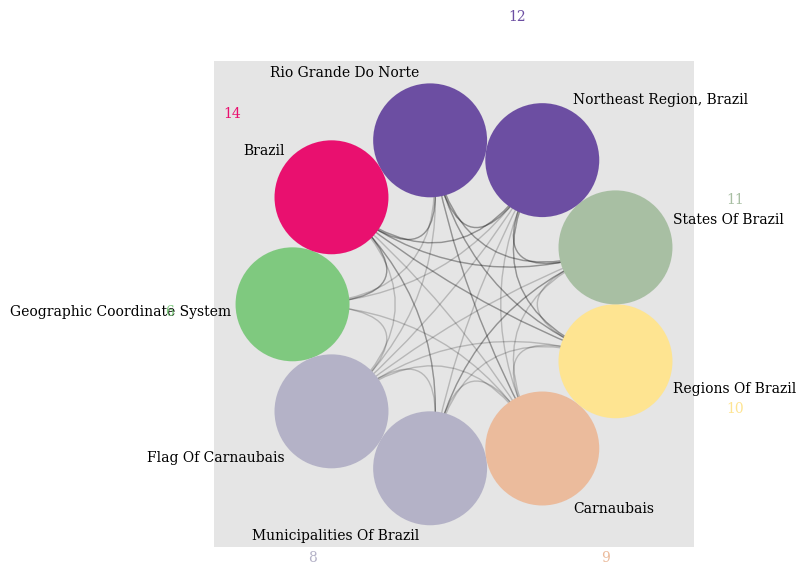

In [41]:
#plotagem de gráfico indicando a quantidade de conexões de cada nó por cor
import nxviz
from nxviz.plots import CircosPlot
c = CircosPlot(
    gsub,
    node_grouping="class",
    node_color="class",
    node_order="class",
    node_labels=True,
    group_label_position="middle",
    group_label_color=True,
    group_label_offset=1,
)
c.draw()
plt.show()

### Requisito 2

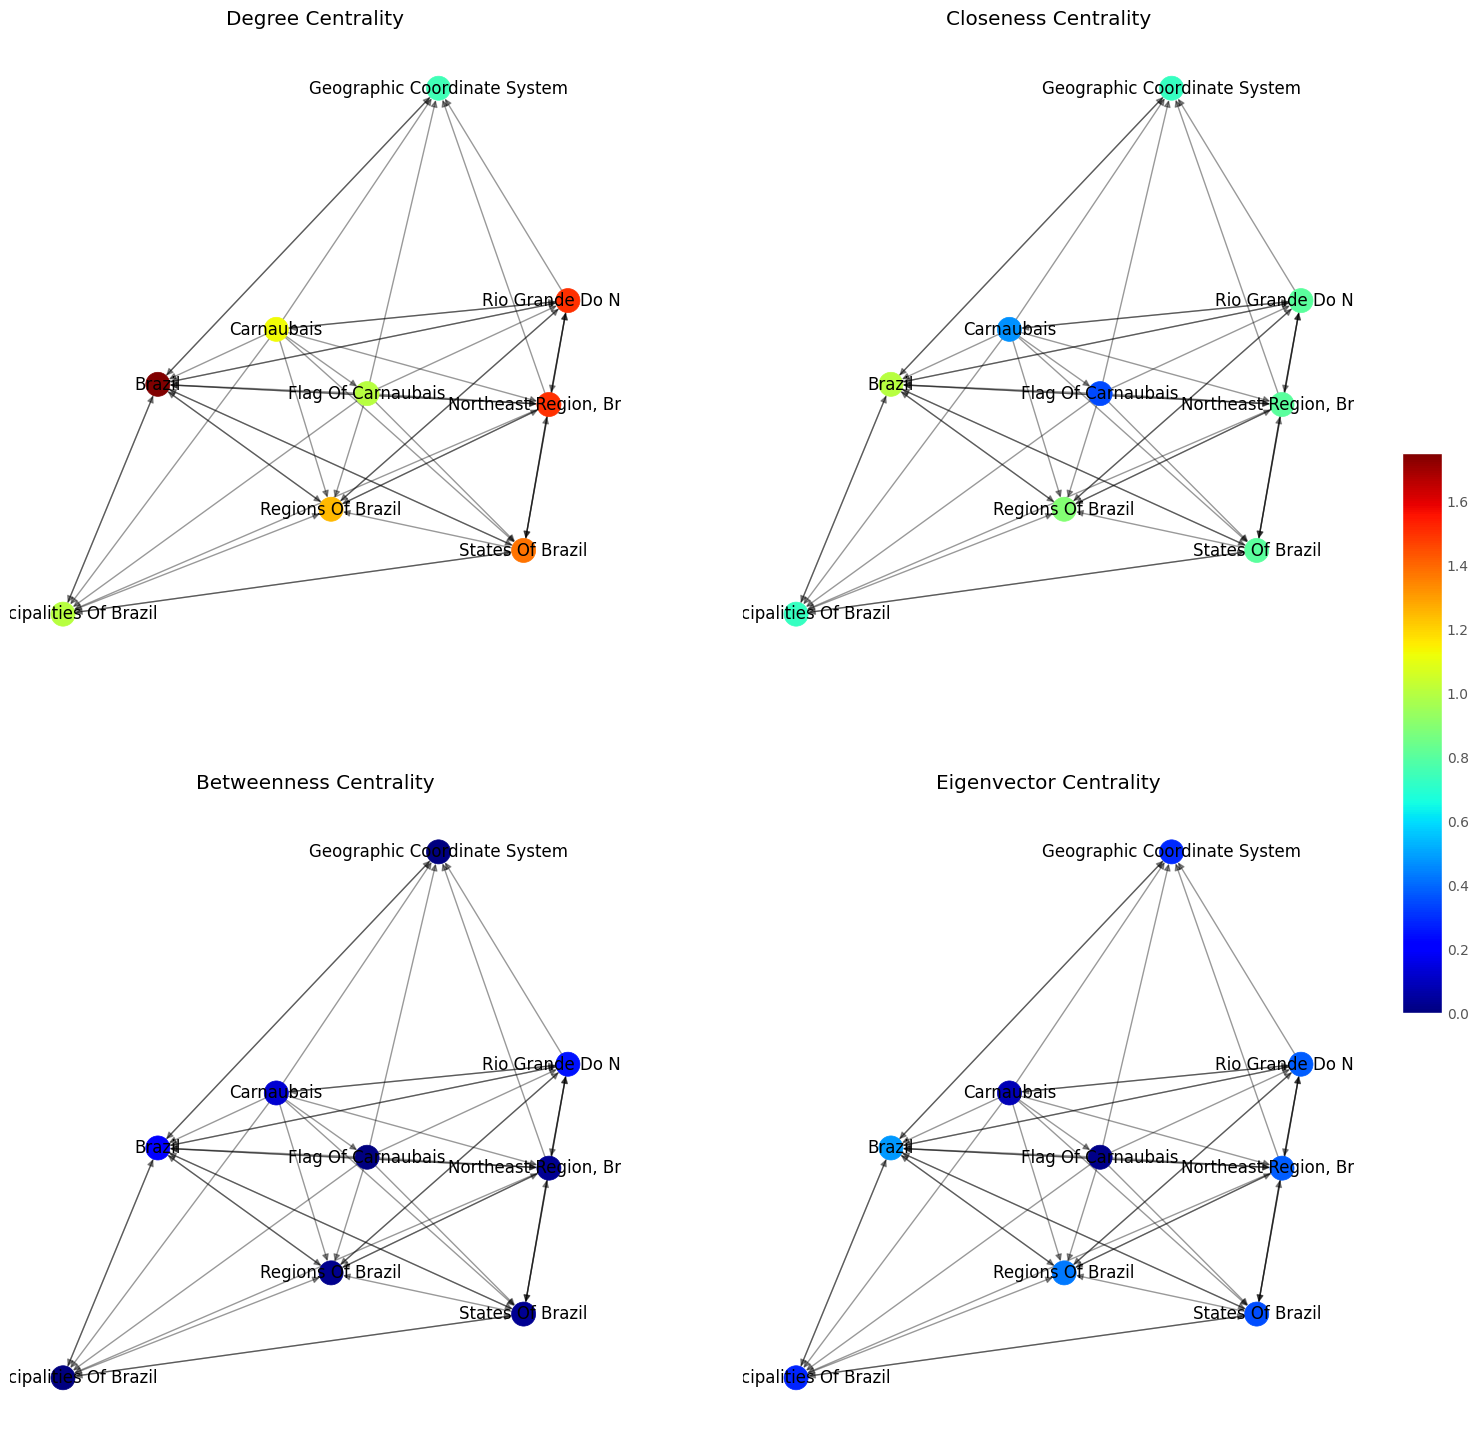

In [42]:
# Plotagem dos 4 gráficos de cada métrica que definem a importância dos nós (eigenvector, degree, closeness, betweenness)
# eigenvector centrality verifica se a vizinhança do nó é importante para a rede, originado da algebra linear e semelhante a autovetores.
# degree centrality indica o nó com maior grau de acordo com o numero de vizinhos.
# closeness centrality indica a distancia (proximidade) media de um nó 
# para todos os outros nós da rede (quanto maior o valor, o nó está mais próximo de todos os outros) 
# pode ser util para transmissao de informações entre os nós.
# betweenness centrality útil para entendimento de fluxo, calcula quantas vezes determinado nó (c) fez parte de um caminho entre um nó a e b
# quanto maior o valor, mais o nó faz parte do fluxo de informação da rede.


fig, ax = plt.subplots(2,2,figsize=(16,14))

# max value of metrics 
max_centrality = max([max([v for k, v in nx.eigenvector_centrality(gsub).items()]),
                      max([v for k, v in nx.degree_centrality(gsub).items()]),
                      max([v for k, v in nx.closeness_centrality(gsub).items()]),
                      max([v for k, v in nx.betweenness_centrality(gsub).items()])])

# layout position
pos = nx.spring_layout(gsub,seed=123456789,k=0.3)

# color of nodes
color_degree = list(dict(nx.degree_centrality(gsub)).values())
color_closeness = list(dict(nx.closeness_centrality(gsub)).values())
color_betweenness = list(dict(nx.betweenness_centrality(gsub)).values())
color_eigenvector = list(dict(nx.eigenvector_centrality(gsub)).values())

# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax[0,0])

# closeness centrality
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax[0,1])

# betweenness centrality
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax[1,0])

# eigenvector centrality
nx.draw_networkx_edges(gsub,
                       pos=pos,
                       alpha=0.4, ax=ax[1,1])

# draw nodes
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0])
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color_closeness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1])
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color_betweenness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0])
nodes = nx.draw_networkx_nodes(gsub,
                 pos=pos,
                 node_color=color_eigenvector,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1])

# 
# draw labels
#
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax[0,0])
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax[0,1])
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax[1,0])
nx.draw_networkx_labels(gsub, pos=pos,
                        font_color='black', ax=ax[1,1])

# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centrality")
ax[0,1].set_title("Closeness Centrality")
ax[1,0].set_title("Betweenness Centrality")
ax[1,1].set_title("Eigenvector Centrality")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)

plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

### Requisito 3

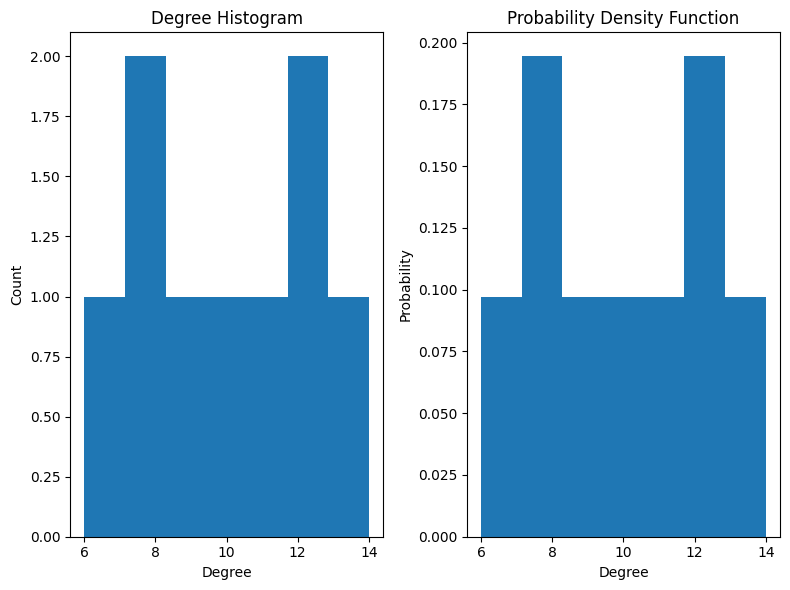

In [43]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

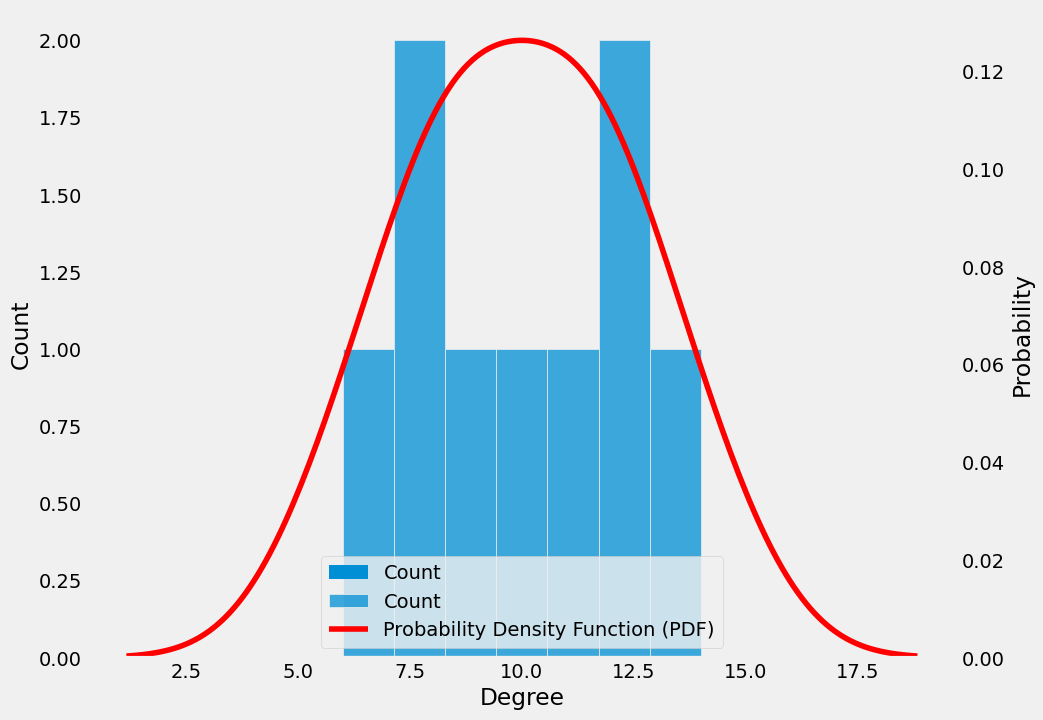

In [44]:
# Grafico densidade probabilidade, analise pela densidade dos nós em relação a rede de acordo com o grau.
# calc the width of each bin using numpy
# diff calc the difference between two positions in the array
bin_width = np.diff(all_data[1])
bin_width
     

# total number of elements in array
all_data[0].sum()
     

# probability density function for each bin
# please check the right figure above and compare the results
all_data[0]/(all_data[0].sum() * bin_width)
     

plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

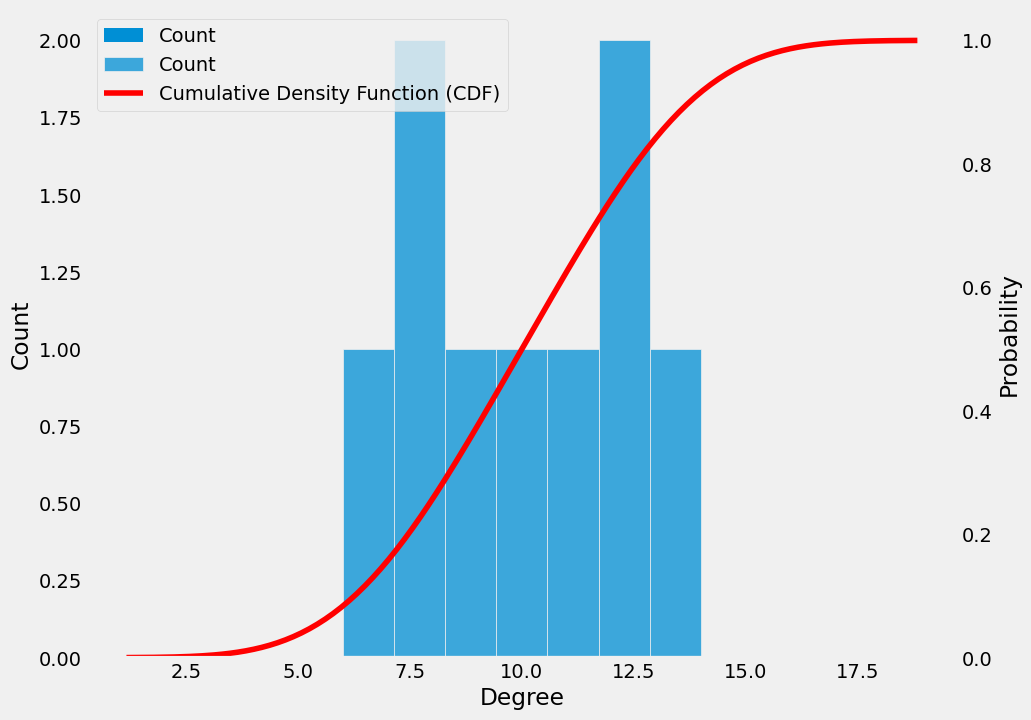

In [45]:
# grafico de densidade cumulativa, indica a porcentagem de conexões que os nós de determinado grau possui em relação às conexões da rede.
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()
     

plt.style.use("ggplot")

### Requisito 4

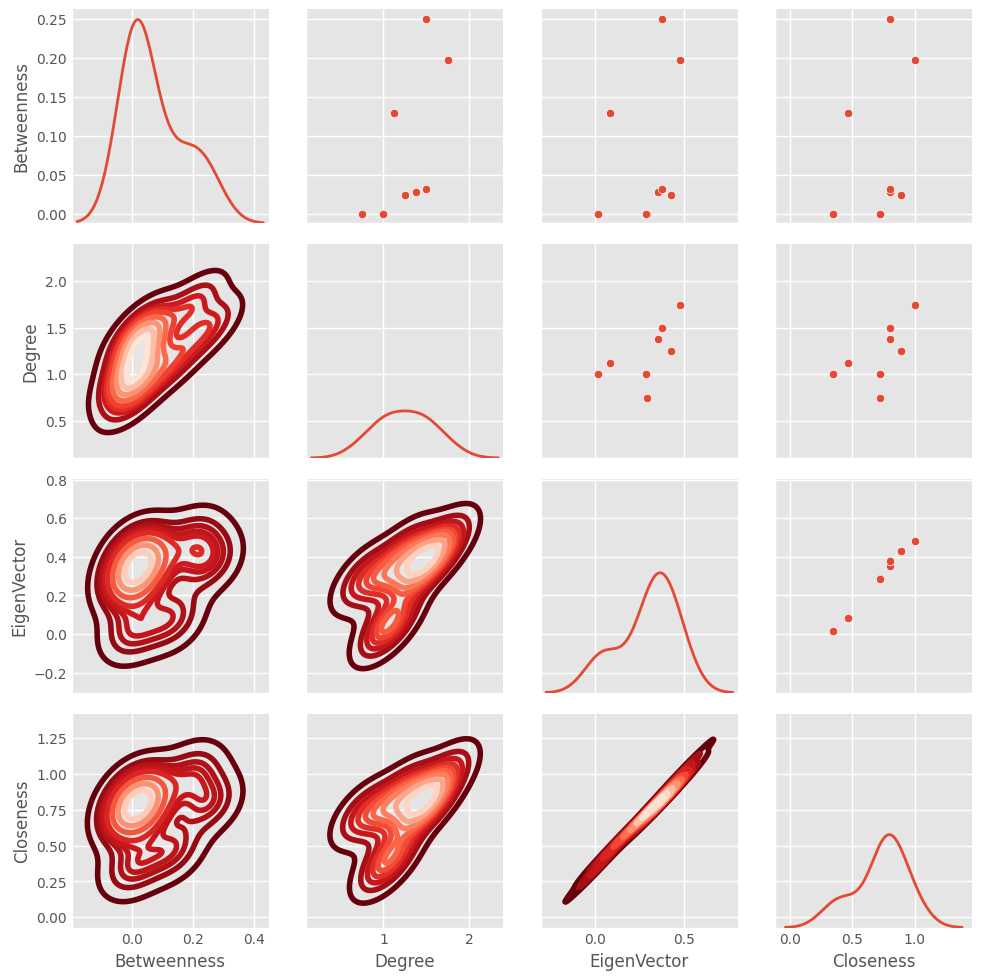

In [46]:
plt.style.use("ggplot")

bc = pd.Series(nx.betweenness_centrality(gsub))
dc = pd.Series(nx.degree_centrality(gsub))
ec = pd.Series(nx.eigenvector_centrality(gsub))
cc = pd.Series(nx.closeness_centrality(gsub))

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)
df.head()

fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()

###  Requisito 5

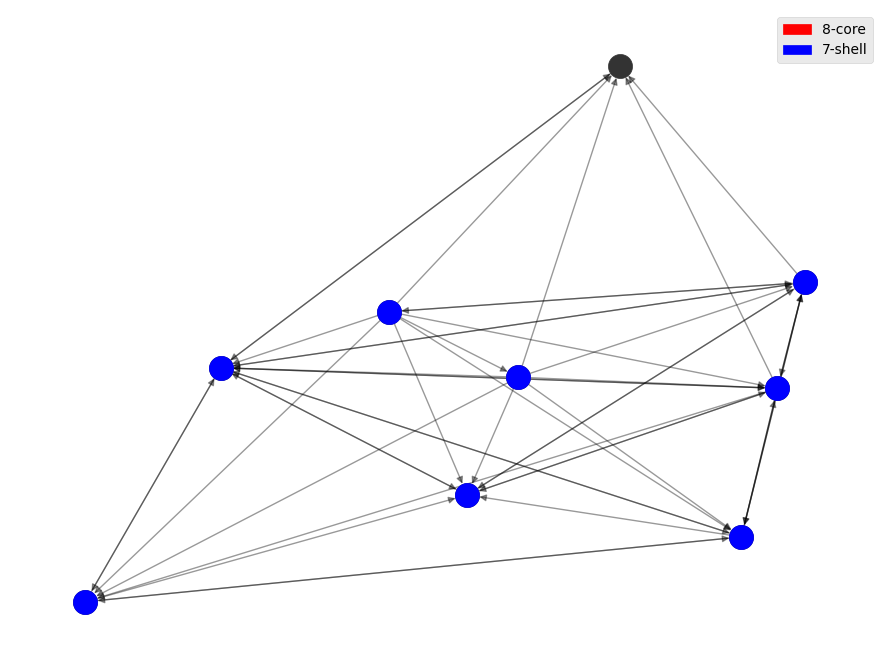

In [47]:
# the degree of network(gsub)
fig, ax = plt.subplots(1,1,figsize=(10,8))
core = [node for node, deg in dict(g.degree()).items() if deg >= 7]
# Find k-cores
gsub_core_13 = nx.k_shell(gsub, 7)
gsub_core_17 = nx.k_core(gsub, 8)
g = nx.subgraph(g, core)
# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color="#333333")

# draw nodes
nodes = nx.draw_networkx_nodes(gsub_core_13,
                 pos=pos,
                 node_color="blue")

nodes = nx.draw_networkx_nodes(gsub_core_17,
                 pos=pos,
                 node_color="red")

# static legend
red_patch = mpatches.Patch(color='red', label='8-core')
blue_patch = mpatches.Patch(color='blue', label='7-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()